In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torch.optim as optim
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import datasets
from torch.utils.data import DataLoader

from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load, backup, load_loss_and_accuracies, save_loss_and_accuracy
from fl_g13.dataset import train_test_split

from fl_g13.architectures import BaseDino
from fl_g13.editing import SparseSGDM

2025-05-07 17:10:37.049 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


In [3]:
# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Use ImageNet stats
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    #Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]), # CIFRAR100 Train stats
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Use ImageNet stats
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

# Always specify a random state, otherwise the split will be different each time 
# If you have intention to load a model mid-training, you may have part of the validation set as already seen in the previous training
train_dataset, val_dataset = train_test_split(cifar100_train, 0.8, random_state=42)
test_dataset = cifar100_test

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


In [4]:
# Move to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"
name="archeops"
start_epoch=1
num_epochs=50
save_every=1
backup_every=10

# Model Hyper-parameters
head_layers=3
head_hidden_size=512
dropout_rate=0.0
unfreeze_blocks=12

# Training Hyper-parameters
batch_size=64
lr=1e-3
momentum=0.9
weight_decay=1e-5
T_max=8
eta_min=1e-5

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model
model = BaseDino(
    head_layers=head_layers, 
    head_hidden_size=head_hidden_size, 
    dropout_rate=dropout_rate, 
    unfreeze_blocks=unfreeze_blocks
    )
model.to(device)

# Optimizer, scheduler, and loss function
mask = [torch.ones_like(p, device=p.device) for p in model.parameters()] # Must be done AFTER the model is moved to CUDA
optimizer = SparseSGDM(
    model.parameters(),
    mask=mask,
    lr=lr,
    momentum=momentum,
    weight_decay=weight_decay
    )
scheduler = CosineAnnealingLR(
    optimizer=optimizer, 
    T_max=T_max, 
    eta_min=eta_min
    )
criterion = CrossEntropyLoss()

all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]       # Pre-allocated list for validation losses
all_training_accuracies=[]    # Pre-allocated list for training accuracies
all_validation_accuracies=[]    # Pre-allocated list for validation accuracies

# ---- RESUME ----

# # Model loading (uncomment to properly overwrite)
# loading_epoch = 25
# model, start_epoch = load(
#     f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.pth",
#     model_class=BaseDino,
#     device=device,
#     optimizer=optimizer,
#     scheduler=scheduler,
#     verbose=True
# )
# model.to(device)
# loaded_metrics = load_loss_and_accuracies(path=f"{CHECKPOINT_DIR}/BaseDino/{name}_BaseDino_epoch_{loading_epoch}.loss_acc.json")

# # Preallocated lists: if the training interrupts, it will still save their values (uncomment to properly load and overwrite)
# all_training_losses=loaded_metrics["train_loss"]       # Pre-allocated list for training losses
# all_validation_losses=loaded_metrics["val_loss"]       # Pre-allocated list for validation losses
# all_training_accuracies=loaded_metrics["train_acc"]    # Pre-allocated list for training accuracies
# all_validation_accuracies=loaded_metrics["val_acc"]    # Pre-allocated list for validation accuracies

# -----------------

print(f"\nModel: {model}")

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main



Model: BaseDino(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm):

In [5]:
try:
    _, _, _, _ = train(
        checkpoint_dir=CHECKPOINT_DIR,
        name=name,
        start_epoch=start_epoch,
        num_epochs=num_epochs,
        save_every=save_every,
        backup_every=backup_every,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        verbose=1,
        all_training_losses=all_training_losses,
        all_validation_losses=all_validation_losses,
        all_training_accuracies=all_training_accuracies,
        all_validation_accuracies=all_validation_accuracies,
    )

except KeyboardInterrupt:
    print("Training interrupted manually.")

except Exception as e:
    print(f"Training stopped due to error: {e}")

Prefix/name for the model was provided: archeops



Training progress: 100%|██████████| 625/625 [03:39<00:00,  2.84batch/s]


🚀 Epoch 1/50 (2.00%) Completed
	📊 Training Loss: 3.3495
	✅ Training Accuracy: 21.18%
	⏳ Elapsed Time: 219.92s | ETA: 10776.30s
	🕒 Completed At: 17:14


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.82batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.8320
	🎯 Validation Accuracy: 49.78%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_1.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_1.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:39<00:00,  2.84batch/s]


🚀 Epoch 2/50 (4.00%) Completed
	📊 Training Loss: 1.3199
	✅ Training Accuracy: 62.00%
	⏳ Elapsed Time: 219.90s | ETA: 10555.07s
	🕒 Completed At: 17:18


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.77batch/s]


🔍 Validation Results:
	📉 Validation Loss: 1.1383
	🎯 Validation Accuracy: 67.11%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_2.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_2.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:40<00:00,  2.84batch/s]


🚀 Epoch 3/50 (6.00%) Completed
	📊 Training Loss: 0.8109
	✅ Training Accuracy: 75.56%
	⏳ Elapsed Time: 220.01s | ETA: 10340.59s
	🕒 Completed At: 17:22


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.65batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9350
	🎯 Validation Accuracy: 72.68%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_3.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_3.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:37<00:00,  2.87batch/s]


🚀 Epoch 4/50 (8.00%) Completed
	📊 Training Loss: 0.5068
	✅ Training Accuracy: 84.05%
	⏳ Elapsed Time: 217.46s | ETA: 10003.29s
	🕒 Completed At: 17:26


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.77batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.7960
	🎯 Validation Accuracy: 76.81%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_4.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_4.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:38<00:00,  2.86batch/s]


🚀 Epoch 5/50 (10.00%) Completed
	📊 Training Loss: 0.2740
	✅ Training Accuracy: 91.22%
	⏳ Elapsed Time: 218.73s | ETA: 9842.66s
	🕒 Completed At: 17:30


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.81batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.6707
	🎯 Validation Accuracy: 81.00%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_5.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_5.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:39<00:00,  2.85batch/s]


🚀 Epoch 6/50 (12.00%) Completed
	📊 Training Loss: 0.1255
	✅ Training Accuracy: 96.17%
	⏳ Elapsed Time: 219.02s | ETA: 9636.91s
	🕒 Completed At: 17:34


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.81batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.6125
	🎯 Validation Accuracy: 83.12%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_6.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_6.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:41<00:00,  2.83batch/s]


🚀 Epoch 7/50 (14.00%) Completed
	📊 Training Loss: 0.0620
	✅ Training Accuracy: 98.45%
	⏳ Elapsed Time: 221.09s | ETA: 9506.67s
	🕒 Completed At: 17:38


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.70batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.5905
	🎯 Validation Accuracy: 84.01%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_7.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_7.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:41<00:00,  2.83batch/s]


🚀 Epoch 8/50 (16.00%) Completed
	📊 Training Loss: 0.0411
	✅ Training Accuracy: 99.18%
	⏳ Elapsed Time: 221.03s | ETA: 9283.29s
	🕒 Completed At: 17:42


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.70batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.5771
	🎯 Validation Accuracy: 84.28%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_8.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_8.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:37<00:00,  2.88batch/s]


🚀 Epoch 9/50 (18.00%) Completed
	📊 Training Loss: 0.0361
	✅ Training Accuracy: 99.37%
	⏳ Elapsed Time: 217.37s | ETA: 8912.18s
	🕒 Completed At: 17:46


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.61batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.5819
	🎯 Validation Accuracy: 84.13%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_9.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_9.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:39<00:00,  2.85batch/s]


🚀 Epoch 10/50 (20.00%) Completed
	📊 Training Loss: 0.0356
	✅ Training Accuracy: 99.35%
	⏳ Elapsed Time: 219.43s | ETA: 8777.04s
	🕒 Completed At: 17:50


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.62batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.5905
	🎯 Validation Accuracy: 84.20%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_10.loss_acc.json

Running backup for epoch 10
💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250507_175108_archeops_BaseDino_epoch_10.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/backup/BaseDino/backup_20250507_175108_archeops_BaseDino_epoch_10.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:40<00:00,  2.83batch/s]


🚀 Epoch 11/50 (22.00%) Completed
	📊 Training Loss: 0.0361
	✅ Training Accuracy: 99.33%
	⏳ Elapsed Time: 220.54s | ETA: 8601.22s
	🕒 Completed At: 17:54


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.61batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.5979
	🎯 Validation Accuracy: 83.70%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_11.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_11.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:42<00:00,  2.81batch/s]


🚀 Epoch 12/50 (24.00%) Completed
	📊 Training Loss: 0.0369
	✅ Training Accuracy: 99.22%
	⏳ Elapsed Time: 222.16s | ETA: 8442.17s
	🕒 Completed At: 17:58


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.69batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.6262
	🎯 Validation Accuracy: 83.42%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_12.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_12.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:43<00:00,  2.80batch/s]


🚀 Epoch 13/50 (26.00%) Completed
	📊 Training Loss: 0.0509
	✅ Training Accuracy: 98.62%
	⏳ Elapsed Time: 223.21s | ETA: 8258.62s
	🕒 Completed At: 18:03


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.67batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.6901
	🎯 Validation Accuracy: 82.43%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_13.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_13.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:44<00:00,  2.78batch/s]


🚀 Epoch 14/50 (28.00%) Completed
	📊 Training Loss: 0.1808
	✅ Training Accuracy: 94.09%
	⏳ Elapsed Time: 224.96s | ETA: 8098.40s
	🕒 Completed At: 18:07


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.77batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.8710
	🎯 Validation Accuracy: 77.85%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_14.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_14.loss_acc.json



Training progress: 100%|██████████| 625/625 [03:41<00:00,  2.82batch/s]


🚀 Epoch 15/50 (30.00%) Completed
	📊 Training Loss: 0.3601
	✅ Training Accuracy: 88.28%
	⏳ Elapsed Time: 221.81s | ETA: 7763.21s
	🕒 Completed At: 18:11


Eval progress: 100%|██████████| 157/157 [00:23<00:00,  6.64batch/s]


🔍 Validation Results:
	📉 Validation Loss: 0.9279
	🎯 Validation Accuracy: 76.09%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_15.pth
💾 Saved losses and accuracies (training and validation) at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/archeops_BaseDino_epoch_15.loss_acc.json



Training progress:   4%|▍         | 28/625 [00:10<03:40,  2.71batch/s]

Training interrupted manually.


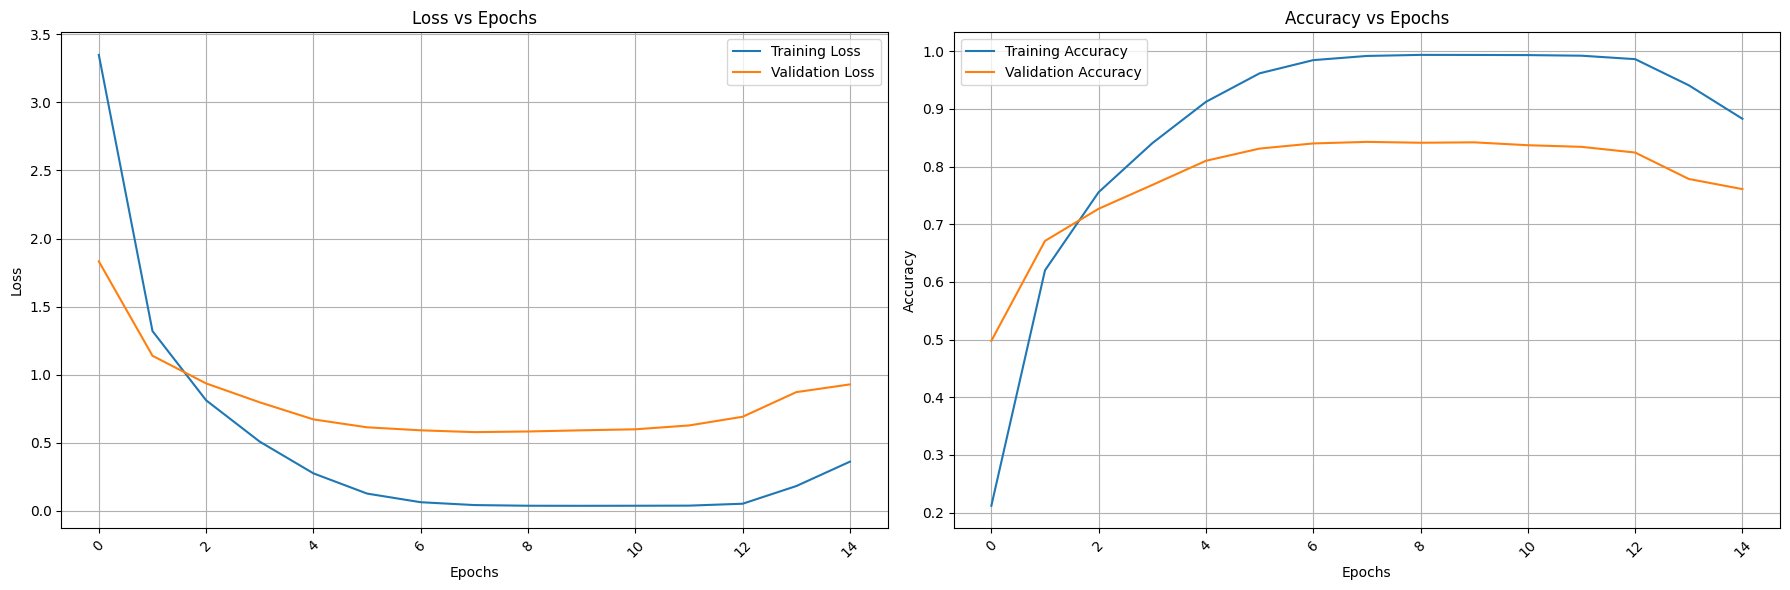

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot losses
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(0, len(all_training_losses)+1, 2), rotation=45)  # Skip every other tick

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid(True)  # Add grid
plt.xticks(range(0, len(all_training_accuracies)+1, 2), rotation=45)  # Skip every other tick

plt.tight_layout()
plt.show()

In [7]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy, _ = eval(dataloader=test_dataloader, model=model, criterion=criterion)

print(
    f"🔍 Test Results:\n"
    f"\t📉 Test Loss: {test_loss:.4f}\n"
    f"\t🎯 Test Accuracy: {100 * test_accuracy:.2f}%"
)

Eval progress: 100%|██████████| 157/157 [00:22<00:00,  6.94batch/s]

🔍 Test Results:
	📉 Test Loss: 0.8868
	🎯 Test Accuracy: 77.01%
